In [360]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

## 1. QA/QC

In [361]:
## input mrna data
mrna_data = pd.read_csv("mrna_data.txt",sep='\t',index_col=1).iloc[:,1:]
mrna_data = mrna_data.dropna(1,how='any') ## drop col full of nan

mrna_data.shape
# scaler = StandardScaler()
# mrna_data_scaled = scaler.fit_transform(mrna_data)

(534, 80)

### 1.1 first run of PCA for checking outliers

[0.70837994 0.05510873 0.03907801 0.03487464 0.03421484 0.00805067
 0.00696289 0.00653336 0.00595071 0.00542694]


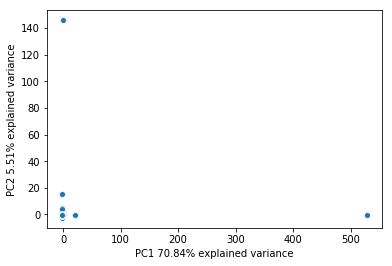

In [362]:
## use pca for visualization
def pca_visulization(mrna_data,ind):
    pca = PCA(n_components=10)
    pca.fit(mrna_data)
    mrnA_pca = pca.transform(mrna_data)

    mrnA_pca = pd.DataFrame(mrnA_pca)
    mrnA_pca.index = ind
    #print(mrnA_pca)

    ## explained var
    explained_var = pca.explained_variance_ratio_
    print(explained_var)

    ## PCA plot 
    sns.scatterplot(x=0, y=1, data=mrnA_pca)
    plt.xlabel("PC1 {:0.2f}% explained variance".format(explained_var[0] *100))
    plt.ylabel("PC2 {:0.2f}% explained variance".format(explained_var[1] *100))
    return mrnA_pca
mrnA_pca = pca_visulization(mrna_data,mrna_data.index)
## there are outliers need to be removed
# plt.xlim([-1.5,1])
# plt.ylim([-1,1])

[0.16487676 0.14710719 0.14412407 0.03398013 0.02937403 0.02756056
 0.0250973  0.02286889 0.01997414 0.01708255]


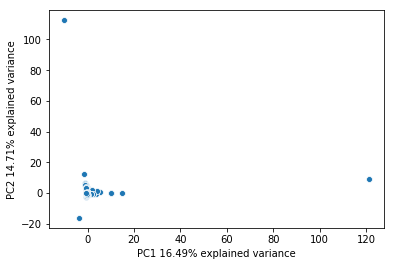

In [363]:
## rm outliner
filtered_ind = mrnA_pca.sort_values(0).iloc[:-2].sort_values(1).iloc[:-1].index
mrna_data_filter = mrna_data.loc[filtered_ind]
mrnA_pca_2 = pca_visulization(mrna_data_filter,mrna_data_filter.index)

## 2. Building model
### 2.1 clean and transform data

In [364]:
## seq data
seq_data = seq_data.dropna(1,how='all') ## rm gene without mutation

## Convert categorical variable into dummy/indicator variables
tem_df = []
for col in seq_data.columns:
    tem = pd.get_dummies(seq_data[col])
    tem.columns = [col + "_" + a for a in tem.columns]
    tem_df.append(tem)
    
seq_data_dum = pd.concat(tem_df,1)

print(seq_data_dum.shape)
seq_data_dum.head()

(534, 105)


,CASR_F788Y,CASR_G325R,CASR_L37Afs*11,CASR_T712I,CASR_V104I,MYH8_A1675V,MYH8_D162Y,MYH8_E1476G D1036G,MYH8_Q1525*,SPON1_X543_splice,...,OR51B4_R124H,OR51B4_V247L,GALNT9_P147Lfs*25,KCNK3_G117D,PCDHB1_G428R,PCDHB1_P467L,PCDHB1_R79S,LRRTM3_L138F,LRRTM3_N233K,LRRTM3_N504K
SAMPLE_ID,,,,,,,,,,,,,,,,,,,,,
CG-B0-5698-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CG-B0-5710-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CG-B0-5711-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CG-B0-5712-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CG-B0-5713-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [365]:
## input mrna data
mrna_data = pd.read_csv("mrna_data.txt",sep='\t',index_col=1).iloc[:,1:]
mrna_data = mrna_data.dropna(1,how='any') ## drop col with full of nan
print(mrna_data.shape)
mrna_data.head()

(534, 80)


,CASR,BEX1,MYH8,SPON1,FABP4,SLITRK5,CBLN2,DGKK,RGS7,SHISA6,...,NMRK2,GAL3ST3,MYMK,PLPPR5,GALNT9,UBE2QL1,KCNK3,PCDHB1,CXADRP3,LRRTM3
SAMPLE_ID,,,,,,,,,,,,,,,,,,,,,
CG-B0-5698-01,-0.1846,1.0774,-0.3371,-0.6924,-0.3928,-0.5263,-0.3020,-0.6173,-0.2393,-0.1344,...,-0.0834,-0.1869,-0.2581,-0.6176,-0.0645,-0.3750,-0.5969,-0.3519,-0.4425,-0.4822
CG-B0-5710-01,-0.2960,-0.3945,-0.3371,-0.6209,0.0998,-0.5013,4.2649,0.4548,0.8915,-0.4898,...,-0.0834,-0.1871,-0.2581,-0.3625,-0.0210,-0.2683,-0.6789,-0.2261,-0.0349,-0.4822
CG-B0-5711-01,-0.3062,-0.1172,-0.3371,0.2032,-0.2344,0.1684,0.0164,1.8246,-0.3062,-0.3022,...,-0.0832,-0.2120,-0.2581,-0.6835,-0.5904,-0.3993,-0.6913,0.0778,0.2538,-0.4822
CG-B0-5712-01,-0.3270,-0.1590,-0.3371,-0.6963,-0.1938,1.2913,-0.3020,-0.6173,8.6926,-0.4933,...,-0.0834,-0.1141,1.5261,-0.7062,-0.3973,-0.3390,-0.5780,-0.3519,-0.4425,-0.4822
CG-B0-5713-01,-0.3130,-0.3992,-0.3371,1.2810,0.9452,-0.1218,-0.2530,-0.6173,-0.3062,-0.3696,...,-0.0834,-0.1705,0.1368,-0.4372,0.2065,-0.2368,0.2235,-0.2526,-0.1206,-0.4822


In [366]:
## clinical data
patient_data = pd.read_csv('patient_data.tsv',sep='\t',index_col=0).T.iloc[1:]
patient_data['Diagnosis Age'] = patient_data['Diagnosis Age'].astype(int)
patient_data['Mutation Count'] = patient_data['Mutation Count'].astype(int)

## transform ages into category
patient_data['Diagnosis Age 2'] = ''
patient_data.loc[patient_data['Diagnosis Age'] <= 40,'Diagnosis Age 2'] = 'youth'
patient_data.loc[(patient_data['Diagnosis Age'] > 40) & (patient_data['Diagnosis Age'] <= 55),'Diagnosis Age 2'] = 'mid age'
patient_data.loc[(patient_data['Diagnosis Age'] > 55),'Diagnosis Age 2'] = 'old age'

patient_data = patient_data[patient_data['Neoplasm Histologic Grade'].notnull()]
patient_data = patient_data[patient_data["Patient's Vital Status"].notnull()]

# y_os = patient_data['Overall Survival (Months)']
# y_st = patient_data['American Joint Committee on Cancer Tumor Stage Code']
# y_gr = patient_data['Neoplasm Histologic Grade']
# y_vs = patient_data["Patient's Vital Status"]

In [367]:
patient_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 527 entries, CG-A3-3387 to CG-MM-A563
Data columns (total 16 columns):
# Samples per Patient                                       527 non-null object
Profiled in Mutations                                       446 non-null object
Profiled in Putative copy-number alterations from GISTIC    519 non-null object
American Joint Committee on Cancer Tumor Stage Code         527 non-null object
Cancer Type                                                 527 non-null object
Diagnosis Age                                               527 non-null int64
Informed consent verified                                   527 non-null object
Neoplasm Histologic Type Name                               527 non-null object
Overall Survival (Months)                                   527 non-null object
Neoplasm Histologic Grade                                   527 non-null object
Race Category                                               520 non-null object
Overa

In [368]:
patient_data.groupby('Neoplasm Histologic Grade').size()

Neoplasm Histologic Grade
G1     14
G2    227
G3    205
G4     76
GX      5
dtype: int64

In [369]:
patient_data_2 = patient_data.drop(['Overall Survival Status','Diagnosis Age','Mutation Count','Diagnosis Age','Cancer Type','Neoplasm Histologic Type Name','# Samples per Patient','Overall Survival (Months)','American Joint Committee on Cancer Tumor Stage Code','Neoplasm Histologic Grade',"Patient's Vital Status"],1).fillna('nan')

## Convert categorical variable into dummy/indicator variables
tem_df = []
for col in patient_data_2.columns:
    tem = pd.get_dummies(patient_data_2[col]).iloc[:,:-1]
    tem.columns = [col + "_" + a for a in tem.columns]
    tem_df.append(tem)
    
patient_data_3 = pd.concat(tem_df+[patient_data[['Mutation Count','Overall Survival (Months)','American Joint Committee on Cancer Tumor Stage Code','Neoplasm Histologic Grade',"Patient's Vital Status"]]],1)
patient_data_3.head()

,Profiled in Mutations_Yes,Profiled in Putative copy-number alterations from GISTIC_Yes,Informed consent verified_NO,Race Category_ASIAN,Race Category_BLACK OR AFRICAN AMERICAN,Race Category_WHITE,Sex_Female,Sex_MALE,Diagnosis Age 2_mid age,Diagnosis Age 2_old age,Mutation Count,Overall Survival (Months),American Joint Committee on Cancer Tumor Stage Code,Neoplasm Histologic Grade,Patient's Vital Status
CG-A3-3387,1,1,0,0,0,1,0,0,1,0,70,20.27,T1a,G2,Alive
CG-A3-3374,1,1,0,0,1,0,1,0,1,0,934,43.17,T1b,G2,Alive
CG-A3-3363,1,1,1,1,0,0,0,0,1,0,1392,10.48,T2,G2,Alive
CG-CZ-5460,1,1,0,0,0,1,0,0,1,0,52,94.38,T3b,G2,Alive
CG-BP-4176,1,1,0,0,0,1,0,0,0,1,85,64.22,T1b,G2,Alive


In [370]:
two_combined = pd.merge(seq_data_dum,mrna_data,left_index=True,right_index=True)
print('seq_data + mrna_data')
print(two_combined.shape)
two_combined['merge_id'] = two_combined.index.str[:-3]

all_combined = pd.merge(two_combined,patient_data_3,left_on='merge_id',right_index=True).drop('merge_id',1)
print('seq_data + mrna_data + patient_data')
print(all_combined.shape)

seq_data + mrna_data
(488, 185)
seq_data + mrna_data + patient_data
(482, 200)


### 2.2 modeling

In [371]:
y = all_combined.iloc[:,-4:]
X = all_combined.iloc[:,:-4]

X_train, X_test,y_train, y_test = train_test_split(X,y)

import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

In [337]:
train_acc = []
test_acc = []
for n in [100,200,500,1000,1500,2000]:
    rfc = RandomForestRegressor(n_estimators=n)
    scores = cross_validate(rfc,X_train,y_train.iloc[:,0],scoring='r2')
    train_acc.append(np.mean(scores['train_score']))
    test_acc.append(np.mean(scores['test_score']))
    
print(train_acc)
print(test_acc)

[0.854135723195796, 0.860016912457071, 0.8588140180099354, 0.8605255554964925, 0.8607574023906993, 0.8598468628183493]
[-0.0071888556040713425, -0.013374193347830632, -0.015028320412239634, -0.008628681054669185, -0.012297046441634873, -0.012882886082321465]


In [279]:
train_acc = []
test_acc = []
for n in [100,200,500,1000,1500,2000]:
    rfc = RandomForestClassifier(n_estimators=n)
    scores = cross_validate(rfc,X_train,y_train.iloc[:,1],scoring='accuracy')
    train_acc.append(np.mean(scores['train_score']))
    test_acc.append(np.mean(scores['test_score']))
# import sklearn
# sorted(sklearn.metrics.SCORERS.keys())

In [280]:
print(train_acc)
print(test_acc)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.338778585597513, 0.3607640599041762, 0.36096739551185597, 0.32520442759520246, 0.35827583454205064, 0.36089396876463825]


In [323]:
train_acc = []
test_acc = []
for n in [100,200,500,1000,1500,2000]:
    rfc = RandomForestClassifier(n_estimators=n)
    scores = cross_validate(rfc,X_train,y_train.iloc[:,2],scoring='accuracy')
    train_acc.append(np.mean(scores['train_score']))
    test_acc.append(np.mean(scores['test_score']))

In [324]:
print(train_acc)
print(test_acc)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.47371156112718316, 0.48748718066461555, 0.5069327731092437, 0.5127416540386647, 0.4930660788905726, 0.4903326904532304]


In [325]:
train_acc = []
test_acc = []
for n in [100,200,500,1000,1500,2000]:
    rfc = RandomForestClassifier(n_estimators=n)
    scores = cross_validate(rfc,X_train,y_train.iloc[:,3],scoring='roc_auc')
    train_acc.append(np.mean(scores['train_score']))
    test_acc.append(np.mean(scores['test_score']))

In [326]:
print(train_acc)
print(test_acc)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.6704179365384441, 0.6905059352205228, 0.6929953415154261, 0.6938464988147862, 0.6930536869754628, 0.6958988861737275]


In [331]:
rfc = RandomForestClassifier(n_estimators=500)
rfc.fit(X_train,y_train.iloc[:,3])


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [336]:
survival = pd.DataFrame(rfc.feature_importances_)
survival.index = X_train.columns
survival[0].sort_values()

C16ORF78_R40Q             0.000000
ROS1_D725N                0.000000
OR51B4_V247L              0.000000
OR51B4_R124H              0.000000
CHRNA4_R566Q              0.000000
SORCS1_D508E              0.000000
MS4A3_X206_splice         0.000000
ROS1_T243K                0.000000
ROS1_X1441_splice         0.000000
SLC6A17_E53Gfs*13         0.000000
FGF7_T27S                 0.000000
DEFA4_S59P                0.000000
SLITRK6_Q116K             0.000000
SCG2_S285Qfs*26           0.000000
FOXP2_T293I               0.000000
SLITRK6_P362T             0.000000
MYH4_N981Tfs*16           0.000000
NTRK2_D275Ifs*33          0.000000
CAPSL_P25R                0.000000
STARD6_P58T               0.000000
MYH4_Y311F R252T D242V    0.000000
KCTD8_K127R               0.000000
F12_V111G                 0.000000
FGF7_C133Y K131=          0.000000
ABCG8_G432D               0.000000
Sex_MALE                  0.000000
DPEP1_R96W                0.000000
CASR_T712I                0.000000
CASR_V104I          

## sandbox

In [320]:
X.iloc[:,-20:]

,GAL3ST3,MYMK,PLPPR5,GALNT9,UBE2QL1,KCNK3,PCDHB1,CXADRP3,LRRTM3,Profiled in Mutations_Yes,Profiled in Putative copy-number alterations from GISTIC_Yes,Informed consent verified_NO,Race Category_ASIAN,Race Category_BLACK OR AFRICAN AMERICAN,Race Category_WHITE,Sex_Female,Sex_MALE,Diagnosis Age 2_mid age,Diagnosis Age 2_old age,Mutation Count
SAMPLE_ID,,,,,,,,,,,,,,,,,,,,
CG-B0-5698-01,-0.1869,-0.2581,-0.6176,-0.0645,-0.3750,-0.5969,-0.3519,-0.4425,-0.4822,1,1,0,0,1,0,0,0,0,1,64
CG-B0-5710-01,-0.1871,-0.2581,-0.3625,-0.0210,-0.2683,-0.6789,-0.2261,-0.0349,-0.4822,1,1,0,0,0,1,0,0,0,1,33
CG-B0-5711-01,-0.2120,-0.2581,-0.6835,-0.5904,-0.3993,-0.6913,0.0778,0.2538,-0.4822,1,1,0,0,0,1,0,0,1,0,32
CG-B0-5712-01,-0.1141,1.5261,-0.7062,-0.3973,-0.3390,-0.5780,-0.3519,-0.4425,-0.4822,1,1,0,0,1,0,1,0,0,1,99
CG-B0-5713-01,-0.1705,0.1368,-0.4372,0.2065,-0.2368,0.2235,-0.2526,-0.1206,-0.4822,1,1,0,0,0,1,1,0,0,1,93
CG-B0-5812-01,-0.1445,0.1376,-0.6813,-0.7237,-0.1103,-0.8302,-0.1528,0.5252,0.4956,1,1,0,0,0,1,0,0,1,0,37
CG-B4-5832-01,-0.2306,-0.2581,0.5778,-0.7788,-0.3882,0.1779,-0.3519,0.2608,1.1170,1,1,0,0,0,1,0,0,0,1,71
CG-B4-5834-01,-0.1164,-0.2581,-0.4029,0.2983,-0.1067,-0.7140,1.1564,0.4741,-0.0190,1,1,0,0,0,1,0,0,0,1,25
CG-B4-5835-01,-0.1508,-0.2581,-0.1935,-0.7885,-0.4075,-0.9148,0.7546,-0.4425,-0.4822,1,1,0,0,0,1,1,0,0,1,77
